<h1><center>Canny Edge Detection</center></h1>

Canny Edge Detection is an algorithm that helps in sketching the edges in an image.

Canny Edge detection is the upgrade of sobel edge detection. Where It is better at removing edges we are not really interested in, and only keep the main edges. In general, canny works by first taking our image and converting it to greyscale, running it on gaussian blur, draw our sobel operator, and then we are ready for canny's process. We start by thinning the edges by using local maximum (Thresholding).


<h3>Steps:</h3>

1. `Noise reduction`
2. `Gradient calculation`
3. `Non-maximum suppression`
4. `Double threshold`
5. `Edge Tracking by Hysteresis`

## `1) Convert to GreyScale` 

In [1]:

import numpy as np
import os
import cv
import matplotlib.pyplot as plt

We must convert the image to grey scale, because this will confuse the step of non-maximum suppression, as the image will 
have multiple channels and will ignore maximums of lower channels. 

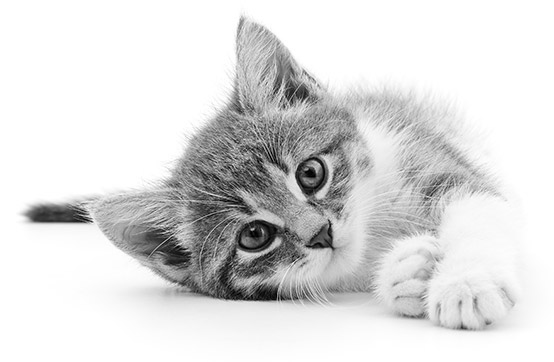

In [2]:
from PIL import Image

img = Image.open('cats.jpg')
imgGray = img.convert('L')
imgGray 

We need to change the image into a matrix of numbers

In [3]:
from numpy import array
I = array(imgGray)
I

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [4]:
print(len(I[0]))
print(len(I))


554
362


## `2) Noise Reduction`

We will be using Gaussian Blur. This will take the image and using a convolution filter it will translate a set of pixels into one pixel, this will help lower the resolution of the image, which will make it easier to form edges.



![Equation](gaussian_filter.png)



This function creates the convolution filter 

In [5]:
def gaussianBlur(vertical,horizontal,sigma):
    #we are creating a matrix that is all zeros
    gauss=np.zeros((vertical,horizontal))
    #we need to have the kernel cell value
    vertical = vertical //2
    horizontal = horizontal //2
    #loop through the 2d array and calculate the G(x,y) accordingly
    for x in range(-vertical,vertical+1):
        for y in range(-horizontal, horizontal+1):
            x1 = 1/(sigma*(2*np.pi)**2)
            x2 = np.exp(-(-x**2+y**2))/(2*sigma**2)
            gauss[x+vertical][y+horizontal]= x1*x2
    return gauss

This function is used to create the destination pixel from source pixels and convolution pixels 

![zerofilter](zero_and_image.png)

In [8]:
def convelotional_kernal(img, mask):
    # figure out the size of the rows, columns of the image
    row,col = img.shape
    # figure out the size of the rows and columns of the filter 
    vertical,horizontal = mask.shape
    #create a matrix that will is bigger than the image to have a zero border 
    new = np.zeros((row+vertical-1, col+horizontal-1))
    horizontal= horizontal//2
    vertical = vertical//2
    #this will contain the result of the image after applying the mask
    filtered_img = np.zeros(img.shape)
    #put image inside the zero's matrix 
    new[vertical: new.shape[0]-vertical , horizontal:new.shape[1]-horizontal] = img
    for i in range(vertical, new.shape[0]-vertical):
        for j in range(horizontal, new.shape[1]-horizontal):
            temp = new [i-vertical: i+vertical+1, j-vertical:j+vertical+1]
            result = temp * mask
            filtered_img[i-vertical, j-horizontal] = result.sum()
    return filtered_img

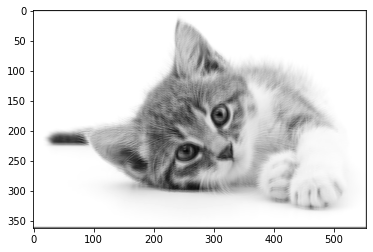

In [9]:
g = gaussianBlur(5,5,1.4)
n = convelotional_kernal(I,g)
plt.imshow(n,cmap='gray')
plt.show()

## `3) Gradient Calculation`

The Gradient calculation step detects the edges' :

1. Intensity 
2. Direction

by calculating the gradient of the image using edge detection operators. 

![intensity](intensity_sobel_filter.png)
![direction](direction_sobel_filter.png)

![direction](sobel_operator.png)

We are trying to find the regions with high level of intensity change. The Kx is trying to find the difference between the left and right side. 

In [11]:

def sobel_filters(img):
    # our x and y kernels 
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    # The  x direction of edges
    Ix = convelotional_kernal(img, Kx)
    # the y direction of edges
    Iy = convelotional_kernal(img, Ky)
    
    #The total x and y direction
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

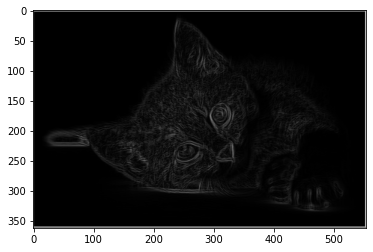

In [14]:
Direction, Theta = sobel_filters(n)
plt.imshow(Direction,cmap='gray')
plt.show()

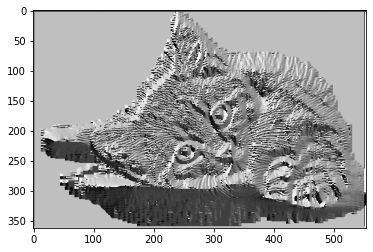

In [15]:
Direction, Theta = sobel_filters(n)
plt.imshow(Theta,cmap='gray')
plt.show()

## `4) Non-maximum suppression`

The edges of the previous image are thick and of different thicknesses. So we will use Non-maximum suppression to 
solve this.

 The algorithm goes through all the points on the gradient intensity matrix and finds the pixels with the maximum value in the edge directions.

`Steps:`

1. Create a matrix initialized to 0 of the same size of the original gradient intensity matrix
2. Identify the edge direction based on the angle value from the angle matrix
3. Check if the pixel in the same direction has a higher intensity than the pixel that is currently processed
4. Return the image processed with the non-max suppression algorithm

![direction](non_max.png)

In [27]:
def non_max_suppression(Direction, theta):
    #we are finding the rows and columns of the image 
    vertical, horizontal = Direction.shape
    # we are creating a matrix with all zeros that we will use to add the new edges
    output = np.zeros((vertical,horizontal))
    # we are changing the theta to be represented as angles for easier comparsion 0<= angle <= 360
    angle = theta * 180. / np.pi
    #any angle that is negative will be incremented by 180 to be positive 
    angle[angle < 0] += 180

    
    # loop through the entire image 
    for i in range(1,vertical-1):
        for j in range(1,horizontal-1):
            try:
                q = 255
                r = 255
                

               #======== we are pinpointing the p and r according to the angle  
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = Direction[i, j+1]
                    r = Direction[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = Direction[i+1, j-1]
                    r = Direction[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = Direction[i+1, j]
                    r = Direction[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = Direction[i-1, j-1]
                    r = Direction[i+1, j+1]

                # if the angle pinpointed is darker than the one we are comparing with then we will add this is our edge 
                if (Direction[i,j] >= q) and (Direction[i,j] >= r):
                    output[i,j] = Direction[i,j]
                else:   #else, we will keep the value as zero
                    output[i,j] = 0

            except IndexError as e:
                pass
    
    return output

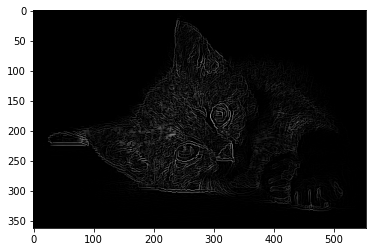

In [28]:
Img_4  = non_max_suppression(Direction, Theta)
plt.imshow(Img_4,cmap='gray')
plt.show()

## `5) Double threshold`

The above image still has variation, so double threshold will identify wether the edges are strong, weak or noise.


![double](double_threshold.jpeg)

In [29]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    #find the highThreshold by finding the maximum pixel and multiply it with the high threshold ratio
    highThreshold = img.max() * highThresholdRatio
    #find the low threshold  
    lowThreshold = highThreshold * lowThresholdRatio
    
    #finding the rows and columns
    vertical, horizontal = img.shape
    #create a zero image to have our results
    result = np.zeros((vertical,horizontal))
    
    #specifying the pixel number that we will give for weak and strong pixels  
    weak = 25  # very dark  
    strong = 255 # white
    
    #categorize the i and j accorsing to where it lies between the low and high threshold 
    strong_i, strong_j = np.where(img >= highThreshold)
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    #after knowing the weak and strong pixels, we will start to fill them with the correct color
    result[strong_i, strong_j] = strong
    result[weak_i, weak_j] = weak
    
    return (result, weak, strong)

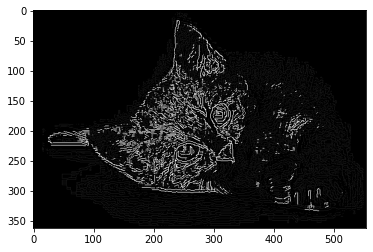

In [30]:
result, weak, strong = threshold(Img_4, 0.005, 0.2)
plt.imshow(result,cmap='gray')
plt.show()

## `6) Edge Tracking by Hysteresis`

hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one

In [22]:
def hysteresis(img, weak, strong=255):
    #know the rows and columns 
    vertical, horizontal = img.shape  
    #loop through the image 
    for i in range(1, vertical-1):
        for j in range(1, horizontal-1):
            # if this particular pixel is considered weaak 
            if (img[i,j] == weak):
                try:
                    #is any of the surrounding pixels strong? if so then label it as strong 
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong) or (img[i-1, j-1] == strong)
                    or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else: #else, make this pixel turn to black 
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

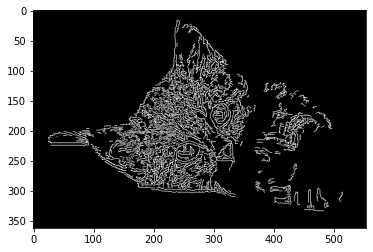

In [24]:
final = hysteresis(result,weak, strong)
plt.imshow(final,cmap='gray')
plt.show()

<h2>Theoretical Analysis</h2>

Most steps in this algorithm move on the entire picture, 

As the picture has width * height dimension in pixels, it is represented in a matrix 

And the algorithm passes on each cell an executes certain steps. Thus 
the complexity can be considered as O(width * height)

1. `Noise reduction`
O(kernel^2)
2. `Gradient calculation`
O(width*height)
3. `Non-maximum suppression`
O(Width*height)
4. `Double threshold`
O(1)
5. `Edge Tracking by Hysteresis`
O(Width*height)

Thus the overall complexity is O(width*height)